In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from numpy.random import randint, randn
from numpy import mean, ones, expand_dims, zeros
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import ipyplot
import matplotlib.pyplot as plt 
from DiffAugment_tf import DiffAugment

In [2]:
!nvidia-smi

Fri Apr 28 09:46:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 463.15       Driver Version: 463.15       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          TCC  | 00000000:01:00.0 Off |                    0 |
| 23%   39C    P8    21W / 235W |      9MiB / 11448MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


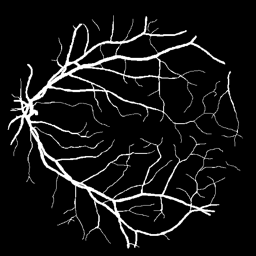


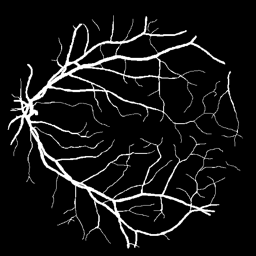


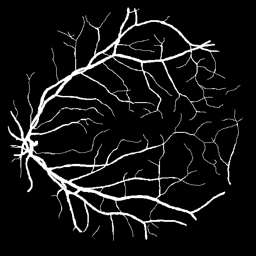


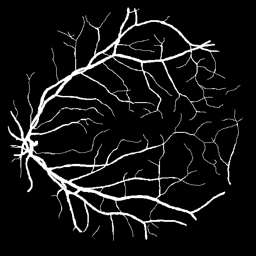


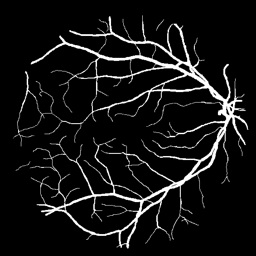


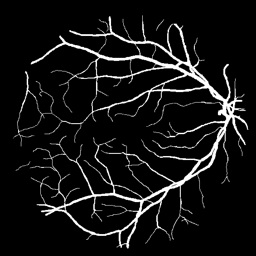


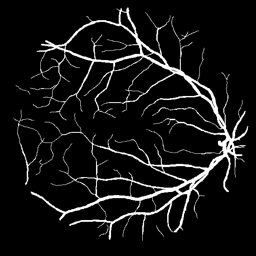


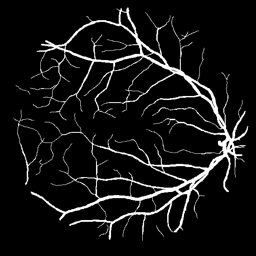


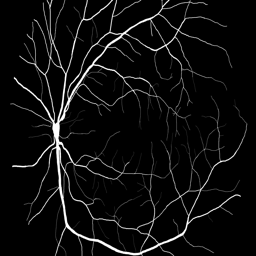


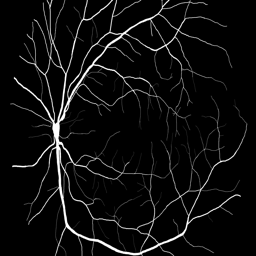


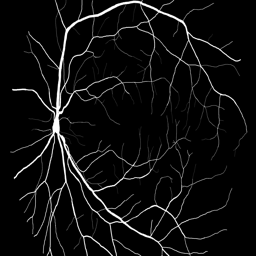


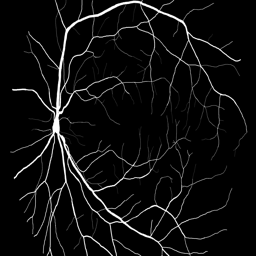


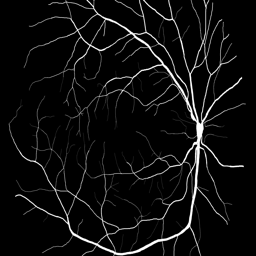


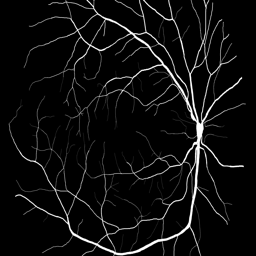


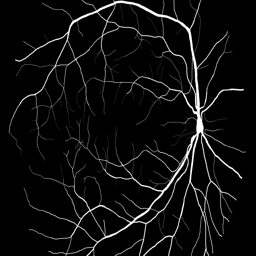


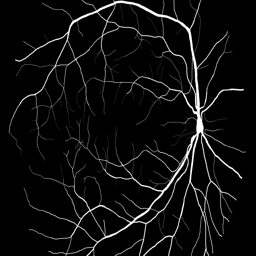

(260, 256, 256)

In [3]:
#Load training images

import os
import numpy as np
from PIL import Image

images_path='C:\\Users\\HP\\ga3\\1st_manual'

training_data = []
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 training_data.append(np.asarray(image))
a=np.array(training_data)

vertical_img=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_TOP_BOTTOM)
 vertical_img.append(np.asarray(img))
vertical_img=np.array(vertical_img) 

horizontal_img=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_LEFT_RIGHT)
 horizontal_img.append(np.asarray(img))
horizontal_img=np.array(horizontal_img)

vertical_img_flip=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_TOP_BOTTOM)
 img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
 vertical_img_flip.append(np.asarray(img))
vertical_img_flip=np.array(vertical_img_flip) 


ipyplot.plot_images(a[[0]])
ipyplot.plot_images(vertical_img[[0]])
ipyplot.plot_images(horizontal_img[[0]])
ipyplot.plot_images(vertical_img_flip[[0]])

data=np.concatenate(( a,vertical_img, horizontal_img, vertical_img_flip))




images_path='C:\\Users\\HP\\ga3\\HRF\\manual1'

hrf = []
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 hrf.append(np.asarray(image))
hrf=np.array(hrf)

hrf_v=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_TOP_BOTTOM)
 hrf_v.append(np.asarray(img))
hrf_v=np.array(hrf_v)

hrf_h=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_LEFT_RIGHT)
 hrf_h.append(np.asarray(img))
hrf_h=np.array(hrf_h)

hrf_vh=[]
for filename in os.listdir(images_path):
 path = os.path.join(images_path, filename)
 image=Image.open(path)
 img = image.transpose(method=Image.FLIP_TOP_BOTTOM)
 img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
 hrf_vh.append(np.asarray(img))
hrf_vh=np.array(hrf_vh)


ipyplot.plot_images(hrf[[0]])
ipyplot.plot_images(hrf_v[[0]])
ipyplot.plot_images(hrf_h[[0]])
ipyplot.plot_images(hrf_vh[[0]])

hrf_data=np.concatenate((hrf, hrf_v, hrf_h, hrf_vh))


all_data=np.concatenate((data, hrf_data))
all_data.shape

In [4]:
all_data=expand_dims(all_data, axis=-1)
all_data.shape

(260, 256, 256, 1)

In [5]:
all_data=all_data.astype('float32')
all_data = (all_data - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
buffer_size = all_data.shape[0]
batch_size = 13
dataset_train = tf.data.Dataset.from_tensor_slices(all_data)
dataset_train = dataset_train.shuffle(buffer_size).batch(batch_size)

In [2]:
image_shape=(256,256,1)

In [3]:
#Discriminator

def Discriminator(image_shape):
    discriminator=Sequential()
    #small batch size =large momentum 0.9-0.99
    discriminator.add(Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=image_shape))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same'))
    #discriminator.add(BatchNormalization(momentum=0.9))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
    #discriminator.add(BatchNormalization(momentum=0.9))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'))
    #discriminator.add(BatchNormalization(momentum=0.9))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(filters=512, kernel_size=(5,5), strides=(2,2), padding='same'))
    #discriminator.add(BatchNormalization(momentum=0.9))
    discriminator.add(LeakyReLU(alpha=0.2))

    discriminator.add(Conv2D(filters=1, kernel_size=(5,5), strides=(1,1), padding='same'))
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    #discriminator.add(Activation('sigmoid'))

    return discriminator

In [4]:
discriminator=Discriminator(image_shape)
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       8

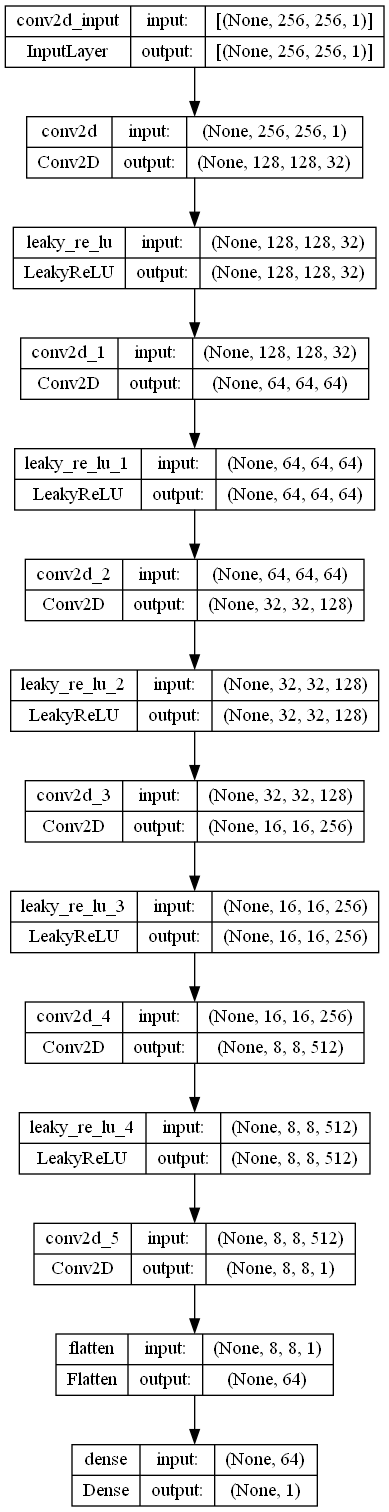

In [5]:
plot_model(discriminator, to_file='wgan_discriminator.png', show_shapes=True, show_layer_names=True)

In [6]:
#Generator

def Generator():
    generator=Sequential()

    generator.add(Dense(units=4*4*512, input_shape=(100,)))
    generator.add(Reshape(target_shape=(4,4,512)))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(BatchNormalization(momentum=0.9))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same'))
    generator.add(Activation('tanh'))

    return generator

In [7]:
generator=Generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)       

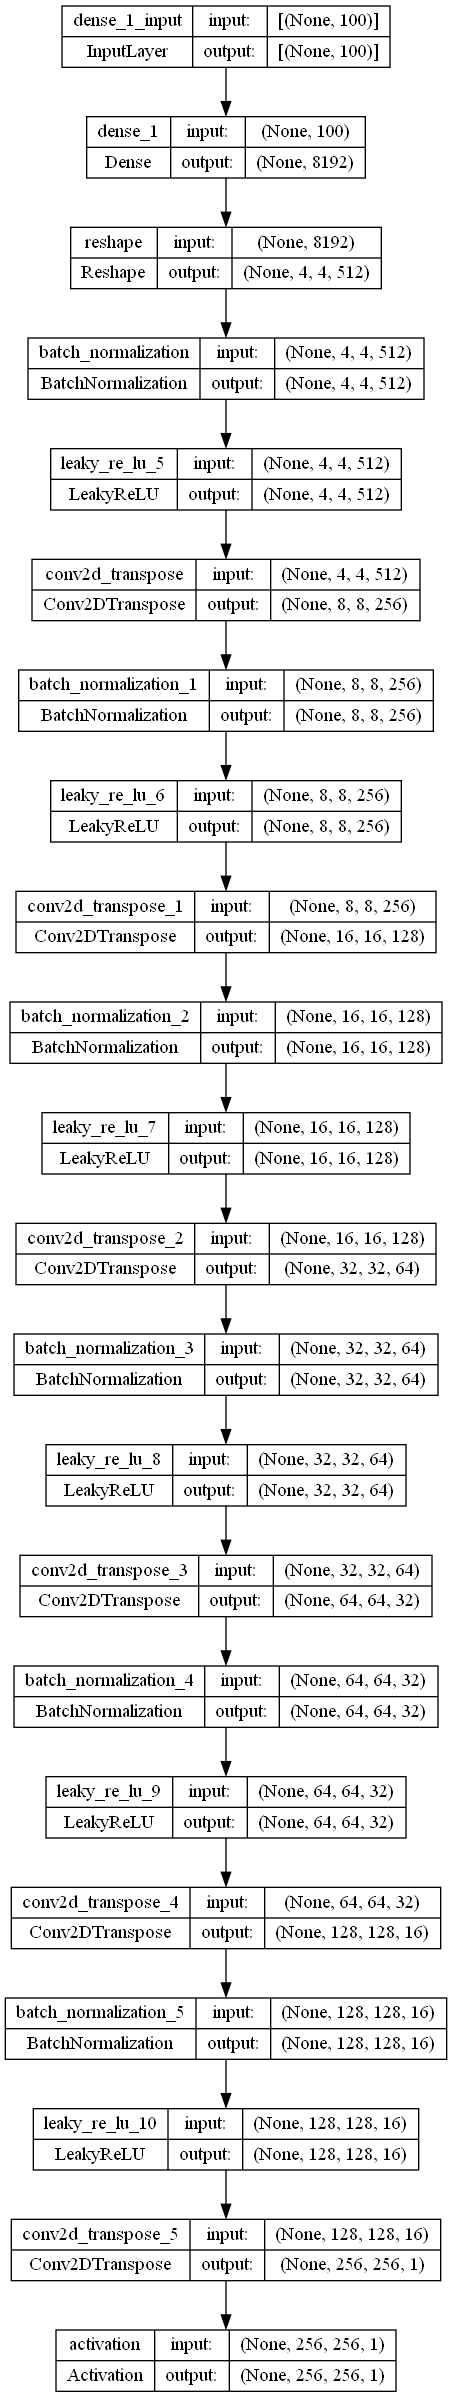

In [8]:
plot_model(generator, to_file='wgan_generator.png', show_shapes=True, show_layer_names=True)

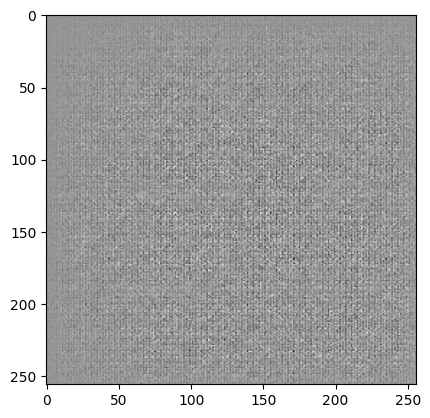

In [12]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
#Loss function
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = -real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [14]:
#optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [16]:
num_examples_to_generate = 9
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        plt.subplot(3,3,i+1)
        plt.axis('off')
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

def plot_history(discriminator_loss, generator_loss):
    #i=1
    #plt.subplot(i,i,1)
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.plot(generator_loss, label='Generator Loss')
    plt.legend()
    plt.savefig('loss_plot_4.png')
    plt.close()

In [17]:
def gradient_penalty(batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        differences = fake_images - real_images
        interpolates = real_images + (alpha * differences)

        gradients = tf.gradients(discriminator(interpolates, training=True), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        return gradient_penalty

In [18]:
#Training steps
@tf.function
def train_step(images):
    latent_dim = 100
      #n_batch = 13
    policy = 'color,translation,cutout'
    noise = tf.random.normal([batch_size, latent_dim])

    disc_train_iterations = 5
    for i in range(disc_train_iterations):
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(DiffAugment(images, policy=policy) , training=True)
            fake_output = discriminator(DiffAugment(generated_images, policy=policy) , training=True)

            disc_loss = discriminator_loss(real_output, fake_output)
            gp = gradient_penalty(batch_size, images, generated_images)
            d_loss = disc_loss + gp * 10
        gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(DiffAugment(generated_images, policy=policy) , training=True)
        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, d_loss

In [19]:
#Train GAN
import os
import time
from IPython.display import clear_output
def train(dataset, epochs):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
    
    
    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=200)
    if ckpt_manager.latest_checkpoint:
        checkpoint.restore(ckpt_manager.latest_checkpoint) 
        print ('Latest checkpoint restored  from '+ckpt_manager.latest_checkpoint)
    d_hist, g_hist = list(), list()
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
        
        if (epoch +701) % 25 == 0:
            generate_and_save_images(generator, epoch + 701, seed)

        d_hist.append(d_loss)
        g_hist.append(g_loss)
        # print(d_hist)
        # print(g_hist)
        plot_history(d_hist, g_hist)

        if (epoch + 701) % 50 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+701,ckpt_save_path))

        if (epoch +701) % 100 == 0:
            clear_output(wait=True)
            generator.save('generator_%06d.tf' % (epoch + 701))
            #discriminator.save('discriminator_%06d.tf' % (epoch + 1))

        print('Epoch %d/%d :: Discriminator loss - %.3f  Generator Loss - %.3f' % (epoch+701, epochs, d_loss, g_loss))
        print ('Time for epoch {} is {} sec'.format(epoch + 701, time.time()-start))



In [20]:
train(dataset_train, 10000)

INFO:tensorflow:Assets written to: generator_004200.tf\assets
Epoch 4200/10000 :: Discriminator loss - -67.006  Generator Loss - -124.066
Time for epoch 4200 is 34.67733120918274 sec
Epoch 4201/10000 :: Discriminator loss - 71.326  Generator Loss - 56.245
Time for epoch 4201 is 31.32639789581299 sec
Epoch 4202/10000 :: Discriminator loss - -2.541  Generator Loss - 427.264
Time for epoch 4202 is 31.333032846450806 sec
Epoch 4203/10000 :: Discriminator loss - -143.764  Generator Loss - 217.506
Time for epoch 4203 is 31.328980207443237 sec


In [62]:
for image_batch in dataset_train:
    print(image_batch.shape)

(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
(13, 256, 256, 1)
